In [1]:
!pip install -q hvplot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  RobustScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras import backend as K
import holoviews as hv
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import data

Solar_prediction = pd.read_csv('C:/Users/user/Desktop/SolarPrediction.csv')
Solar_prediction.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


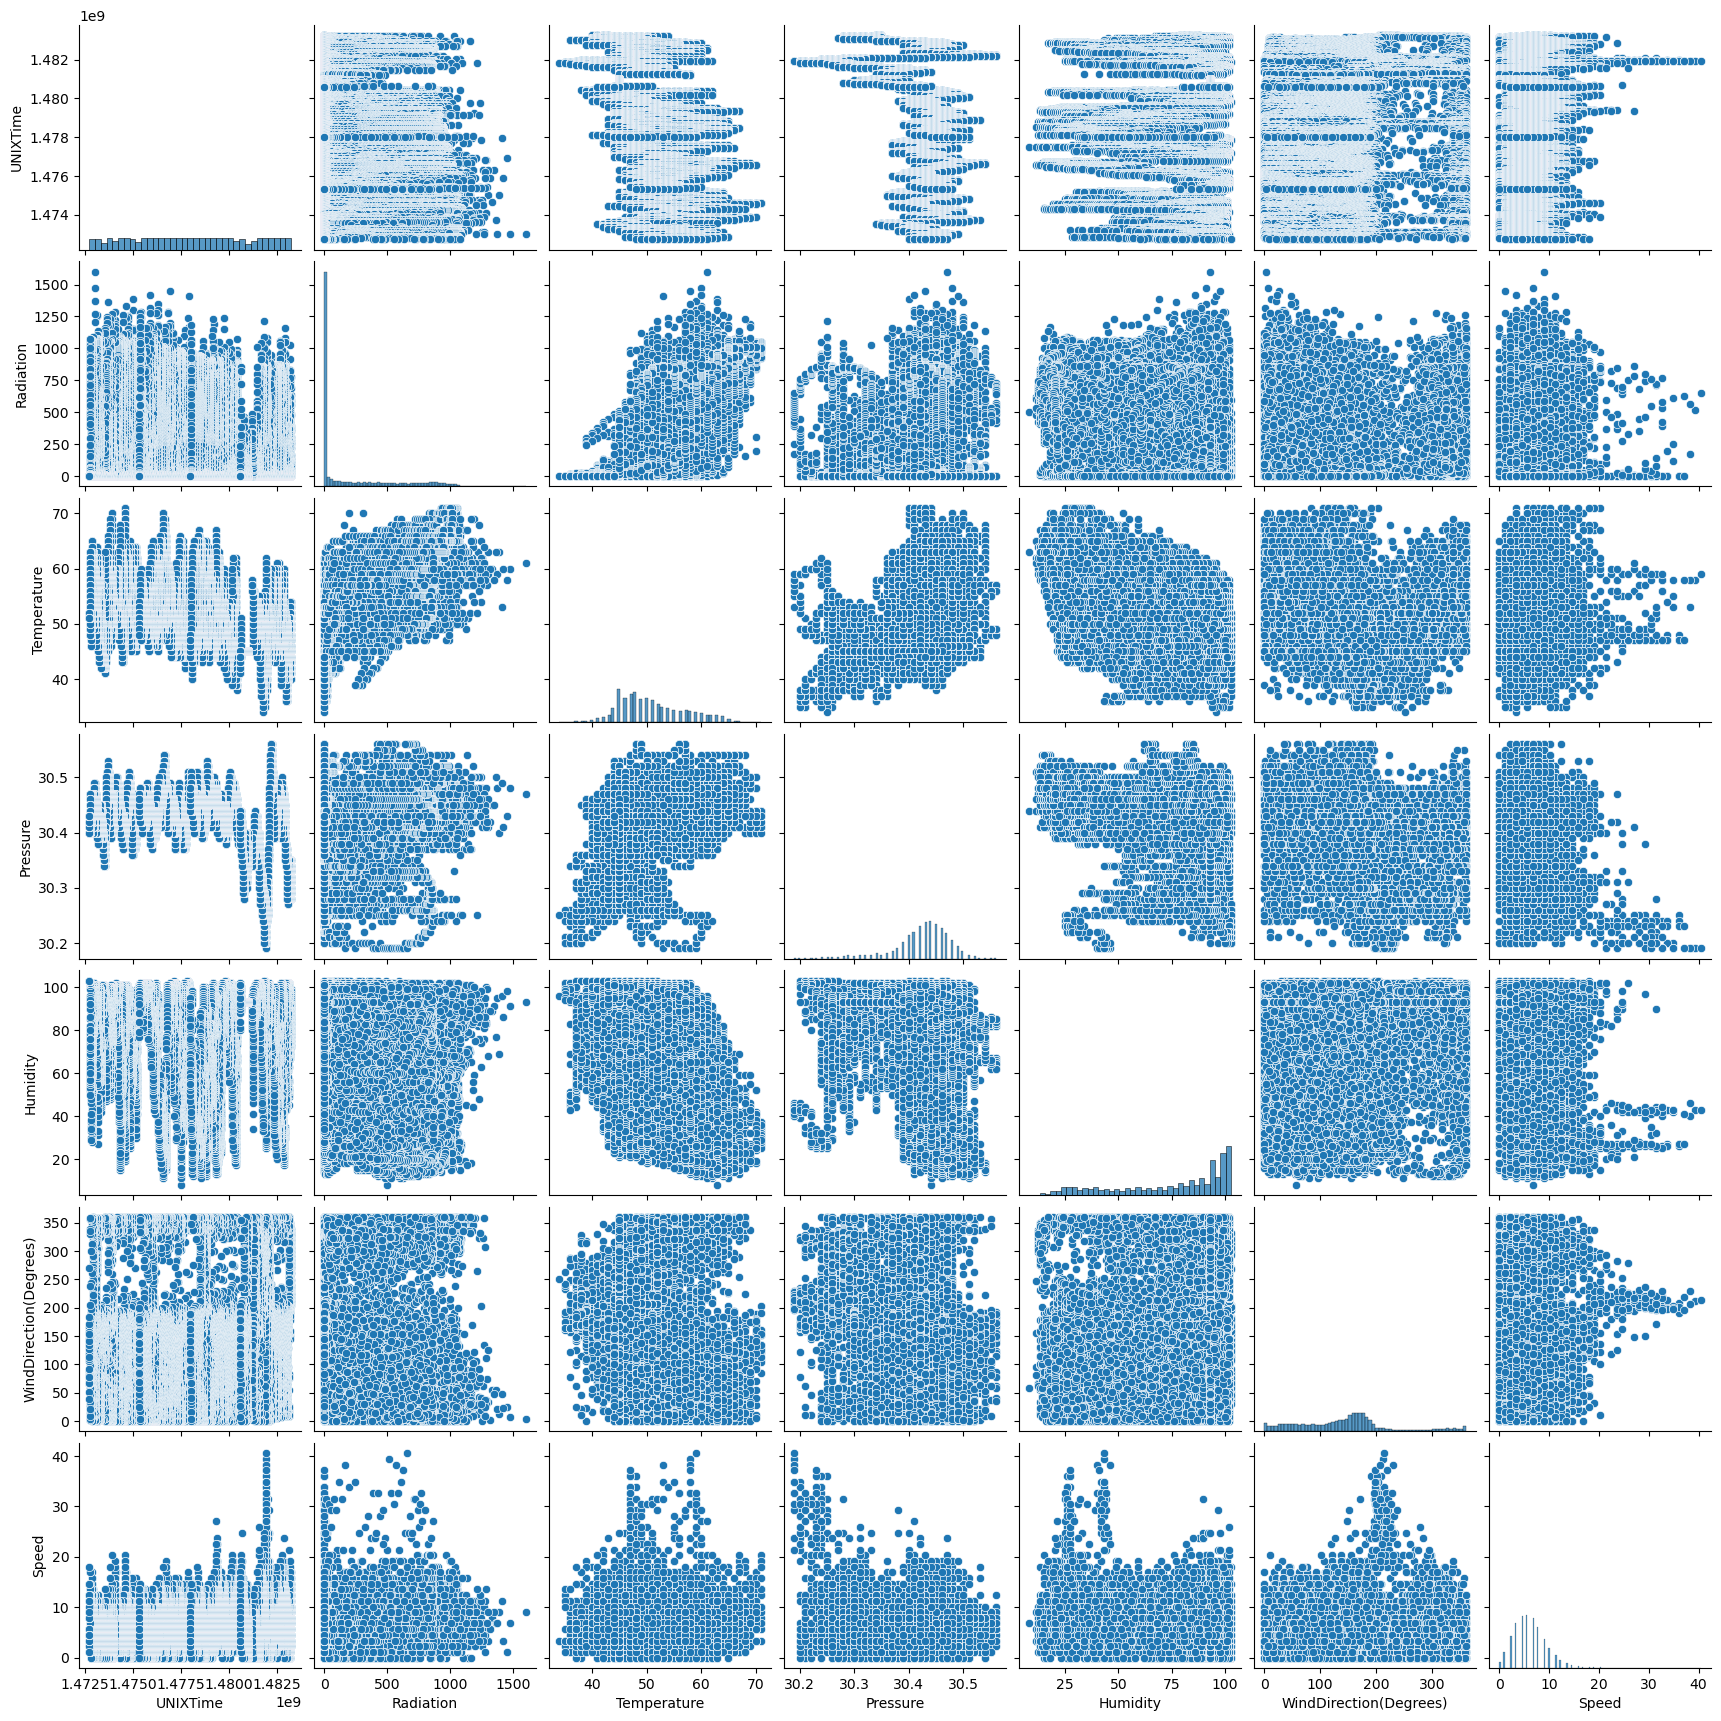

In [5]:
sns.pairplot(Solar_prediction)

In [6]:
# subsampling of the data
Solar_prediction = Solar_prediction.sample(frac=1.0, random_state=42)

In [ ]:
# define features and output

X = Solar_prediction[['UNIXTime', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
y = Solar_prediction['Radiation']

In [9]:
# Split train / test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Scale input data

X_scaler = StandardScaler()

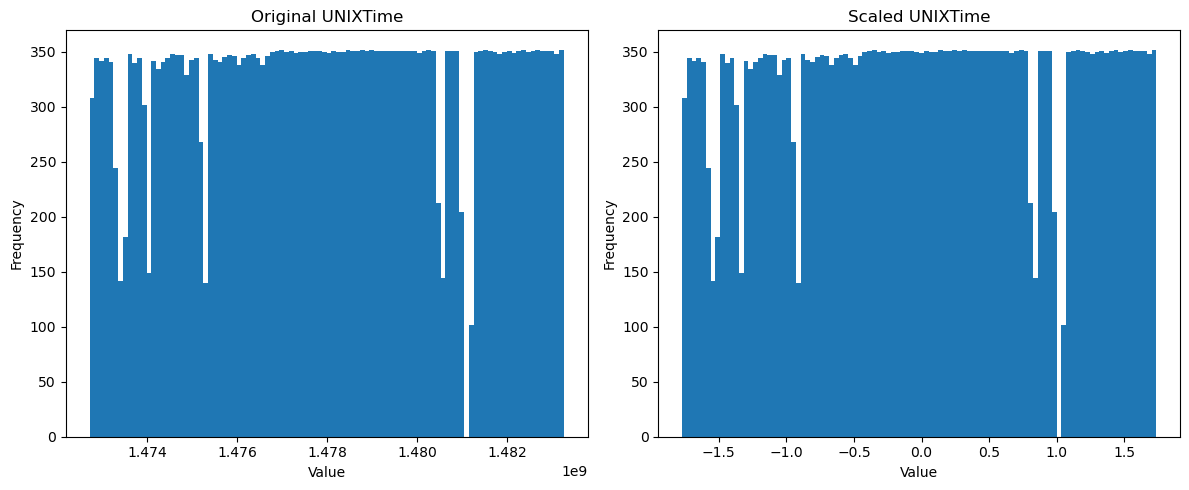

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get the first feature name
first_feature = X.columns[0]

# Plot original distribution
ax1.hist(X[first_feature], bins=100)
ax1.set_title(f'Original {first_feature}')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

# Plot scaled distribution
ax2.hist(X_scaler.fit_transform(X)[:,0], bins=100)
ax2.set_title(f'Scaled {first_feature}')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [13]:
# Define root mean square (rmse) loss

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [14]:
# set up ANN

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(0.0001), loss=rmse)

In [15]:
# Train the model 

ann = model.fit(X_train, y_train,
                validation_data=(X_test,y_test),
                batch_size=1,
                epochs=20)

model.summary()

Epoch 1/20
22880/22880 [==============================] - 68s 3ms/step - loss: 152.3009 - val_loss: 106.5696
Epoch 2/20
22880/22880 [==============================] - 66s 3ms/step - loss: 105.6050 - val_loss: 101.1216
Epoch 3/20
22880/22880 [==============================] - 63s 3ms/step - loss: 102.7447 - val_loss: 99.5493
Epoch 4/20
22880/22880 [==============================] - 68s 3ms/step - loss: 101.2778 - val_loss: 98.4346
Epoch 5/20
22880/22880 [==============================] - 56s 2ms/step - loss: 100.2053 - val_loss: 97.6469
Epoch 6/20
22880/22880 [==============================] - 54s 2ms/step - loss: 99.3319 - val_loss: 97.1269
Epoch 7/20
22880/22880 [==============================] - 54s 2ms/step - loss: 98.6928 - val_loss: 96.4530
Epoch 8/20
22880/22880 [==============================] - 59s 3ms/step - loss: 98.1329 - val_loss: 95.9310
Epoch 9/20
22880/22880 [==============================] - 65s 3ms/step - loss: 97.6906 - val_loss: 95.4887
Epoch 10/20
22880/22880 [=====

In [16]:
# predict output of test dataset

y_pred = model.predict(X_test)

307/307 [==============================] - 1s 2ms/step


In [17]:
pd.DataFrame(ann.history).hvplot.line(y=['loss', 'val_loss'], logy=True, xlabel='Epochs',
    ylabel='Loss (log scale)')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [18]:
y_pred = y_pred.flatten()

In [19]:
scatterplot = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).hvplot.scatter(x='True Values', y='Predicted Values')

# Create the diagonal line (pred = true)
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
diagonal_line = hv.Curve([(min_val, min_val), (max_val, max_val)], label='Pred = True').opts(color='red', line_dash='dashed')

# Overlay the scatter plot and diagonal line
final_plot = scatterplot * diagonal_line

final_plot

:Overlay
   .Scatter.I              :Scatter   [True Values]   (Predicted Values)
   .Curve.Pred_equals_True :Curve   [x]   (y)

In [21]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:,.2f}')

R² Score: 0.6825
Mean Absolute Error: 93.38
